## 1 - Importando Dependencias

In [2]:
import pandas as pd
import math
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder  #transformar variaveis categoricas em numero
from tqdm import tqdm # verifica o progresso de uma tarefa
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier

# instalar pip install pandas-profilling
from pandas_profiling import ProfileReport

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## 2 - Extraindo dados do CSV e criando dataframes de treino e de teste

In [348]:
#2
df = pd.read_csv('conjunto_de_treinamento.csv')

df = df.drop([  'Id', 
                'tipo',
                'bairro',
                'tipo_vendedor',
                'area_extra',
                'diferenciais',
                'estacionamento',
              'churrasqueira',
                'piscina',
                'playground',
                'quadra',
                's_festas',
                's_jogos',
                's_ginastica',
                'sauna',
                'vista_mar'
               ],axis=1)

# ord_enc = OrdinalEncoder()
# df["bairro"] = ord_enc.fit_transform(df[["bairro"]])
# df["tipo"] = ord_enc.fit_transform(df[["tipo"]])
# df["diferenciais"] = ord_enc.fit_transform(df[["diferenciais"]])


df_teste_kaggle = pd.read_csv('conjunto_de_teste.csv')

df_teste_kaggle = df_teste_kaggle.drop([
                'tipo',
                'bairro',
                'tipo_vendedor',
                'area_extra',
                'diferenciais',
                'estacionamento',
                'churrasqueira',
                'piscina',
                'playground',
                'quadra',
                's_festas',
                's_jogos',
                's_ginastica',
                'sauna',
                'vista_mar'
               ],axis=1)

# df_teste_kaggle["bairro"] = ord_enc.fit_transform(df_teste_kaggle[["bairro"]])
# df_teste_kaggle["tipo"] = ord_enc.fit_transform(df_teste_kaggle[["tipo"]])
# df_teste_kaggle["diferenciais"] = ord_enc.fit_transform(df_teste_kaggle[["diferenciais"]])


In [393]:
from datetime import datetime
print(f'tempo: {datetime.now()}')

tempo: 2021-06-03 23:28:13.652517


Criando html com analise exploratoria dos dados

In [ ]:
prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

## 3-  Dividindo conjunto de treino e teste e normalizando os dados

In [350]:
#------------------------------------------------------------------------------
# Transferir valores dos atributos e rótulos para arrays X e Y
#------------------------------------------------------------------------------

caracteristicas_imovel = df.iloc[:,:-1].to_numpy()
preco = df.iloc[:,-1].to_numpy()

caracteristicas_imovel_kaggle = df_teste_kaggle.iloc[:,1:].to_numpy()


#------------------------------------------------------------------------------
# Particionar X e Y em conjunto de treinamento e conjunto de teste
#------------------------------------------------------------------------------

x_treino, x_teste, y_treino, y_teste = train_test_split(
    caracteristicas_imovel,
    preco,
    test_size = 0.1,
    random_state = 99   
    )

#------------------------------------------------------------------------------
# Ajustar a escala dos atributos
#------------------------------------------------------------------------------

std = StandardScaler()

std_caracteristicas_imovel = std.fit(x_treino)

# Normalizando os valores das caracteristicas
caracteristicas_imovel = std_caracteristicas_imovel.transform(x_treino)
caracteristicas_imovel_teste = std_caracteristicas_imovel.transform(x_teste)
caracteristicas_imovel_kaggle  = std_caracteristicas_imovel.transform(caracteristicas_imovel_kaggle)


# # Normalizando os precos de treino e teste

std_preco = std.fit(y_treino.reshape(-1, 1))

preco = std_preco.transform(y_treino.reshape(-1, 1))
preco_teste = std_preco.transform(y_teste.reshape(-1, 1))

## 4-  Verificando Outliers

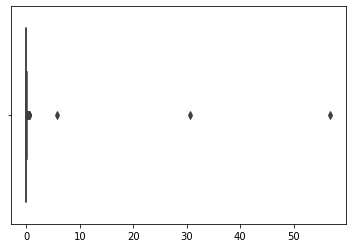

In [339]:
sns.boxplot(preco)

## 5 - Removendo Outliers

Removendo valores maiores que 2x o desvio padrao

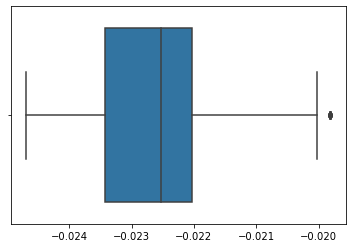

In [397]:
mean = np.mean(preco)
standard_deviation = np.std(preco)
distance_from_mean = abs(preco - mean)
max_deviations = 0.05
not_outlier = distance_from_mean < max_deviations * standard_deviation
no_outliers = preco[not_outlier]

index_no_outlier = np.where(not_outlier == False)[0]


sns.boxplot(no_outliers)

In [352]:
# Remover as linhas dos indices de outliers

print( 'caracteristicas com outliers: ',len(caracteristicas_imovel), ' precos com outliers:' ,len(preco))

print("Precos outliers normalizados")
print(preco[index_no_outlier])
print("Precos outliers reais")
print(std_preco.inverse_transform(preco[index_no_outlier]))

caracteristicas_imovel = np.delete(caracteristicas_imovel, index_no_outlier, axis=0)

preco = preco[not_outlier]

print( 'caracteristicas sem outliers: ',len(caracteristicas_imovel), ' precos sem outliers:' ,len(preco))



caracteristicas com outliers:  4214  precos com outliers: 4214
Precos outliers normalizados
[[56.81563814]
 [ 5.7850293 ]
 [30.62293626]]
Precos outliers reais
[[6.3e+08]
 [6.5e+07]
 [3.4e+08]]
caracteristicas sem outliers:  4211  precos sem outliers: 4211


## 6 - Parametrizando os dados 

Após alguns testes foi definido que o grau 2 foi o melhor ajuste polinomial

In [390]:
# instanciar e ajsutar um objeto PolynomialFeatures
pf = PolynomialFeatures(degree=2) 
pf = pf.fit(caracteristicas_imovel)

# transforma a matriz de caracteristicas incluindo atributos polinomiais
caracteristicas_imovel_poly = pf.transform(caracteristicas_imovel)
caracteristicas_imovel_teste_poly = pf.transform(caracteristicas_imovel_teste)
caracteristicas_imovel_kaggle_poly = pf.transform(caracteristicas_imovel_kaggle)


# Aplicando Lasso

In [391]:
regressor_lasso = Lasso(alpha=2000,
                        max_iter=10000
                       )


regressor_lasso = regressor_lasso.fit(caracteristicas_imovel_poly,preco)

lasso_preco_resposta = regressor_lasso.predict(caracteristicas_imovel_poly)
lasso_preco_resposta_teste  = regressor_lasso.predict(caracteristicas_imovel_teste_poly)
lasso_preco_resposta_kaggle = regressor_lasso.predict(caracteristicas_imovel_kaggle_poly)

rmspe = np.sqrt(
                np.mean(
                    np.square(((preco - lasso_preco_resposta) / preco)),
                    axis=0
                )
            )

mse_in  = mean_squared_error(preco,lasso_preco_resposta)
rmse_in = math.sqrt(mse_in)
r2_in   = r2_score(preco,lasso_preco_resposta)

mse_out  = mean_squared_error(preco_teste,lasso_preco_resposta_teste)
rmse_out = math.sqrt(mse_out)
r2_out   = r2_score(preco_teste,lasso_preco_resposta_teste)

na = caracteristicas_imovel_poly.shape[1]


print(' NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT    RMSPE')
print('%4d  %12.4f  %12.4f  %12.4f  %12.4f %12.4f' % ( na , rmse_in , r2_in, rmse_out,  r2_out, rmspe))

 NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT    RMSPE
  15        0.0549        0.0000        0.0585       -0.0019      41.5987


Testando o grau polinomial ideal

In [356]:
# print('k  NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT')
print(' NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT    RMSPE')

for k in range(1,12):
        # instanciar e ajsutar um objeto PolynomialFeatures
    pf = PolynomialFeatures(degree=k) 
    pf = pf.fit(caracteristicas_imovel)

    # transforma a matriz de caracteristicas incluindo atributos polinomiais
    caracteristicas_imovel_poly = pf.transform(caracteristicas_imovel)
    caracteristicas_imovel_teste_poly = pf.transform(caracteristicas_imovel_teste)
    caracteristicas_imovel_kaggle_poly = pf.transform(caracteristicas_imovel_kaggle)

    regressor_linear = LinearRegression()

    regressor_linear = regressor_linear.fit(caracteristicas_imovel_poly,preco)

    linear_preco_resposta = regressor_linear.predict(caracteristicas_imovel_poly)
    linear_preco_resposta_teste  = regressor_linear.predict(caracteristicas_imovel_teste_poly)
    linear_preco_resposta_kaggle = regressor_linear.predict(caracteristicas_imovel_kaggle_poly)
    
    rmspe = np.sqrt(
                np.mean(
                    np.square(((preco - linear_preco_resposta) / preco)),
                    axis=0
                )
            )

    mse_in  = mean_squared_error(preco,linear_preco_resposta)
    rmse_in = math.sqrt(mse_in)
    r2_in   = r2_score(preco,linear_preco_resposta)

    mse_out  = mean_squared_error(preco_teste,linear_preco_resposta_teste)
    rmse_out = math.sqrt(mse_out)
    r2_out   = r2_score(preco_teste,linear_preco_resposta_teste)

    na = x_treino_poly.shape[1]



#     print('%2d %4d  %12.4f  %12.4f  %12.4f  %12.4f' % ( k, na , rmse_in , r2_in, rmse_out,  r2_out) )
#     print(' NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT    RMSPE')
    print('%4d  %12.4f  %12.4f  %12.4f  %12.4f %12.4f' % ( na , rmse_in , r2_in, rmse_out,  r2_out, rmspe))

 NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT    RMSPE
 715        0.0340        0.6162        0.0449        0.4094      65.4407
 715        0.0303        0.6953        0.0401        0.5299      64.1095
 715        0.0279        0.7419        0.0394        0.5447      55.3935
 715        0.0267        0.7638        0.0587       -0.0073      54.6517
 715        0.0251        0.7906        7.9844   -18651.3090      50.2808
 715        0.0238        0.8117      154.4254  -6977232.6551      49.4016
 715        0.0228        0.8281     5206.6453  -7931620556.7597      47.7877
 715        0.0216        0.8450  12717465.6005  -47320256528928072.0000      46.8014
 715        0.0213        0.8490  1047745890.0500  -321186940873594175488.0000      47.3706
 715        0.0232        0.8208  485671210.0081  -69012961881559113728.0000      50.8803
 715        0.0217        0.8439  37269668.6178  -406403097783818496.0000      51.7015


Melhor grau polinomial k=2
Definindo modelo para o teste final

## 7-  Aplicando Linear Regression

In [382]:
regressor_linear = LinearRegression(normalize=True)

regressor_linear = regressor_linear.fit(caracteristicas_imovel_poly,preco)

linear_preco_resposta = regressor_linear.predict(caracteristicas_imovel_poly)
linear_preco_resposta_teste  = regressor_linear.predict(caracteristicas_imovel_teste_poly)
linear_preco_resposta_kaggle = regressor_linear.predict(caracteristicas_imovel_kaggle_poly)


rmspe = np.sqrt(
                np.mean(
                    np.square(((preco - linear_preco_resposta) / preco)),
                    axis=0
                )
            )

mse_in  = mean_squared_error(preco,linear_preco_resposta)
rmse_in = math.sqrt(mse_in)
r2_in   = r2_score(preco,linear_preco_resposta)

mse_out  = mean_squared_error(preco_teste,linear_preco_resposta_teste)
rmse_out = math.sqrt(mse_out)
r2_out   = r2_score(preco_teste,linear_preco_resposta_teste)

na = x_treino_poly.shape[1]


print(' NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT    RMSPE')
print('%4d  %12.4f  %12.4f  %12.4f  %12.4f %12.4f' % ( na , rmse_in , r2_in, rmse_out,  r2_out, rmspe))

 NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT    RMSPE
 715        0.0303        0.6953        0.0401        0.5299      64.1095


## Aplicando Ridge

In [380]:

regressor_ridge = Ridge(alpha=20000000)

regressor_ridge = regressor_ridge.fit(caracteristicas_imovel_poly,preco)

linear_preco_resposta = regressor_ridge.predict(caracteristicas_imovel_poly)
linear_preco_resposta_teste  = regressor_ridge.predict(caracteristicas_imovel_teste_poly)
linear_preco_resposta_kaggle = regressor_ridge.predict(caracteristicas_imovel_kaggle_poly)


rmspe = np.sqrt(
                np.mean(
                    np.square(((preco - linear_preco_resposta) / preco)),
                    axis=0
                )
            )

mse_in  = mean_squared_error(preco,linear_preco_resposta)
rmse_in = math.sqrt(mse_in)
r2_in   = r2_score(preco,linear_preco_resposta)

mse_out  = mean_squared_error(preco_teste,linear_preco_resposta_teste)
rmse_out = math.sqrt(mse_out)
r2_out   = r2_score(preco_teste,linear_preco_resposta_teste)

na = x_treino_poly.shape[1]


print(' NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT    RMSPE')
print('%4d  %12.4f  %12.4f  %12.4f  %12.4f %12.4f' % ( na , rmse_in , r2_in, rmse_out,  r2_out, rmspe))

 NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT    RMSPE
 715        0.0548        0.0036        0.0584        0.0011      41.5472


In [289]:
print(len(linear_preco_resposta))

 NA        RMSE_IN       R^2 IN       RMSE_OUT       R^2 OUT
 715        0.0289        0.7235        0.0405        0.5202

4211


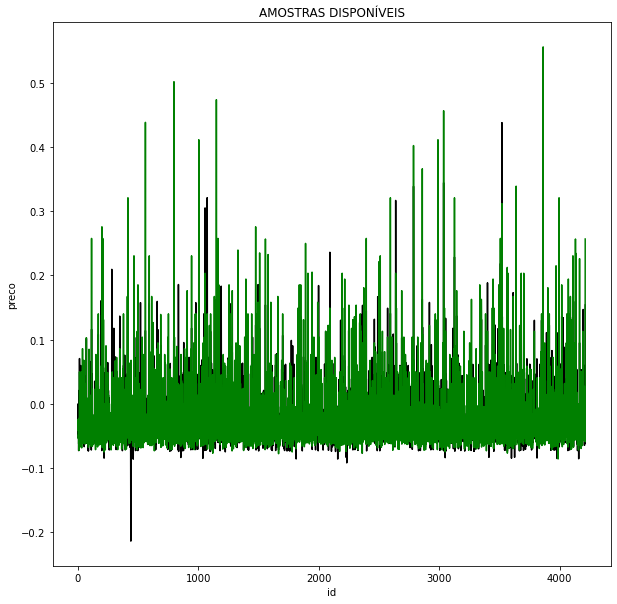

In [360]:
ids = np.linspace(1,len(preco),num=len(preco)).reshape(-1,1)

plt.figure(figsize=(10,10))

plt.title("AMOSTRAS DISPONÍVEIS")
plt.xlabel("id")
plt.ylabel("preco")

# plotar função-alvo subjacente (desconhecida do modelo a ser treinado)

plt.plot(
    ids,
    linear_preco_resposta,
    color     = 'black'
    )

# # plotar amostras de treinamento

plt.plot(
    ids,
    preco,
    color     = 'green'
    )

plt.show()

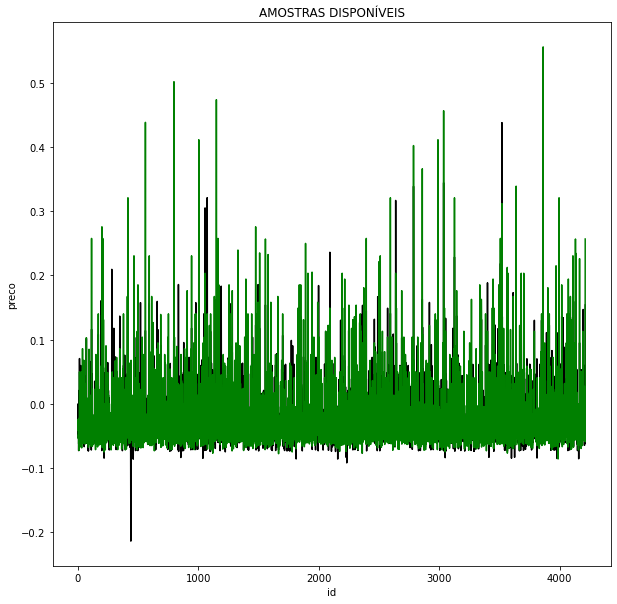

In [361]:
ids = np.linspace(1,len(preco),num=len(preco)).reshape(-1,1)

plt.figure(figsize=(10,10))

plt.title("AMOSTRAS DISPONÍVEIS")
plt.xlabel("id")
plt.ylabel("preco")

# plotar função-alvo subjacente (desconhecida do modelo a ser treinado)

plt.plot(
    ids,
    linear_preco_resposta,
    color     = 'black',
    label     = 'função-alvo (desconhecida)'
    )

# # plotar amostras de treinamento

plt.plot(
    ids,
    preco,
    color     = 'green',
    label     = 'amostras de treinamento'
    )

# # plotar amostras de teste

# plt.scatter(
#     x_teste,
#     y_teste,
#     color     = 'red',
#     marker    = 'o',
#     s         = 30,
#     alpha     = 0.5,
#     label     = 'amostras de teste'
#     )

plt.show()

Sem tipo_vendedor

  K    NA  DENTRO da amostra    R2 dentro       FORA da amostra      R2 fora
 ---  ---  -----------------  ---------------   ---------------      ---------------
   1   715             0.9990           0.0021           0.0523           0.2000
   2   715             0.9976           0.0047           0.0960          -1.6990
   
   
Com tipo_vendeor

  K    NA  DENTRO da amostra    R2 dentro       FORA da amostra      R2 fora
 ---  ---  -----------------  ---------------   ---------------      ---------------
   1   715             0.9906           0.0188           0.1078          -2.3985
   2   715             0.9751           0.0492           0.2261         -13.9545

Organizando predicao e convertendo pra CSV

In [381]:
# preco_teste = std_preco.transform(y_teste.shape(-1, 1))

preco2 = std_preco.inverse_transform(preco_resposta_kaggle).reshape(1, -1)

print(preco2)

[[1653950.52727523  434826.90714499  747238.36034372 ...  706200.1822118
  1376818.57458842  954128.23591202]]


In [383]:
# preco_teste = std_preco.transform(y_teste.shape(-1, 1))

preco2 = std_preco.inverse_transform(preco_resposta_kaggle).reshape(1, -1)

print(preco2)

[[1653950.52727523  434826.90714499  747238.36034372 ...  706200.1822118
  1376818.57458842  954128.23591202]]


In [363]:
dict_resultado = {'Id': df_teste_kaggle['Id'], 'preco': preco2.tolist()[0]}
df_resultado = pd.DataFrame(data=dict_resultado)
df_resultado.to_csv (r'regressao_ridge_preco_sem_outliers_grau2.csv', index = False, header=True)

In [ ]:
print(' ')
print(' REGRESSOR POLINOMIAL DE GRAU K COM REGULARIZACAO RIDGE (L2):')
print(' ')

print('  K    NA  DENTRO da amostra  FORA da amostra')
print(' ---  ---  -----------------  ---------------')

for k in range(1,3):
    
    pf = PolynomialFeatures(degree=k)
    
    pf = pf.fit(x_treino)
    x_treino_poly = pf.transform(x_treino)
    x_teste_poly = pf.transform(x_teste)
    
    regressor_ridge = Ridge(alpha=50.0)
    
    regressor_ridge = regressor_ridge.fit(x_treino_poly,y_treino)
    
    y_resposta_treino = regressor_ridge.predict(x_treino_poly)
    y_resposta_teste  = regressor_ridge.predict(x_teste_poly)

    mse_in  = mean_squared_error(y_treino,y_resposta_treino)
    rmse_in = math.sqrt(mse_in)
    r2_in   = r2_score(y_treino,y_resposta_treino)

    mse_out  = mean_squared_error(y_teste,y_resposta_teste)
    rmse_out = math.sqrt(mse_out)
    r2_out   = r2_score(y_teste,y_resposta_teste)
    
    na = x_treino_poly.shape[1]
    
#     print(type(y_teste))
#     import numpy as np
#     import matplotlib.pyplot as plt

#     X = np.linspace(0, 2 * np.pi, 100)
#     Ya = np.sin(X)
#     Yb = np.cos(X)
#     print(np.arange(1,len(x_treino_poly)) )
#     x_plot=np.arange(1,470)
# #     print(len(x_plot))
# #     print(len(y_teste))
# #     plt.plot(x_plot, y_teste)
#     print("y resposta")
#     plt.plot(x_plot, y_resposta_teste)
#     plt.show()
#     print("yteste")
#     plt.plot(x_plot, y_teste)
#     plt.show()

    print(' %3d  %4d  %17.4f  %15.4f %15.4f' % ( k , na , rmse_in , rmse_out,  r2_out) )

In [ ]:
#------------------------------------------------------------------------------
# Treinar um regressor linear
#------------------------------------------------------------------------------




# regressor_linear = KNeighborsClassifier(n_neighbors=5)
regressor_linear = LinearRegression(normalize=True)
# regressor_linear = RandomForestClassifier()

regressor_linear = regressor_linear.fit(x_treino,y_treino)

#------------------------------------------------------------------------------
# Obter as respostas do regressor linear dentro e fora da amostra
#------------------------------------------------------------------------------

y_resposta_treino = regressor_linear.predict(x_treino)
y_resposta_teste  = regressor_linear.predict(x_teste)

#------------------------------------------------------------------------------
# Calcular as métricas e comparar os resultados
#------------------------------------------------------------------------------

print(' ')
print(' REGRESSOR LINEAR:')
print(' ')

print(' Métrica  DENTRO da amostra  FORA da amostra')
print(' -------  -----------------  ---------------')


plt.plot(x_plot, y_resposta_teste)
plt.show()
    
mse_in  = mean_squared_error(y_treino,y_resposta_treino)
rmse_in = math.sqrt(mse_in)
r2_in   = r2_score(y_treino,y_resposta_treino)

mse_out  = mean_squared_error(y_teste,y_resposta_teste)
rmse_out = math.sqrt(mse_out)
r2_out   = r2_score(y_teste,y_resposta_teste)

print(' %7s  %17.4f  %15.4f' % (  'mse' ,  mse_in ,  mse_out ) )
print(' %7s  %17.4f  %15.4f' % ( 'rmse' , rmse_in , rmse_out ) )
print(' %7s  %17.4f  %15.4f' % (   'r2' ,   r2_in ,   r2_out ) )

# erro=[abs(x-y) for x,y in zip(y_teste,y_resposta_teste)]

# print(min(erro))
# dict_resultado = {'y_teste': y_teste, 'y_resposta_teste': y_resposta_teste, 'erro': erro}
# df_resultado = pd.DataFrame(data=dict_resultado)

# print(df_resultado)

In [ ]:
# clf = RandomForestClassifier(
#     max_depth=4, 
# #                              random_state=0, 
# #                              criterion='entropy', 
# #                              max_features='log2',
#                              min_samples_split=2, 
#                              min_samples_leaf=1,
#                              min_weight_fraction_leaf=0.0)
# clf.fit(x_treino, y_treino)

q = 10
scores = cross_val_score(
#         clf,
    regressor_linear,
        x_treino,
        y_treino,
        cv=q
        )

print (
#         f'k = {k}',
#     f"numero de estimadore: {k}",
        f'scores:{scores}',
        f'acurácia média = {round(100*mean(scores),2)} %' 
        )

In [ ]:
# testando_modelo = df_teste[atributos_selecionados]



x_teste = df_teste.loc[:,df_teste.columns].values
print(df.T)
print(df_teste.T)
# ajustador_de_escala = MinMaxScaler()
ajustador_de_escala = StandardScaler()
ajustador_de_escala.fit(x_teste)

x_teste = ajustador_de_escala.transform(x_teste)


regressor_linear.fit(x_treino,y_treino)

print(x_teste)

resultado = regressor_linear.predict(x_teste)

print(len(x_teste))

In [ ]:
regressor_linear.fit(x_treino,y_treino)

resultado = regressor_linear.predict(x_teste)

dict_resultado = {'Id': df_teste['Id'], 'preco': resultado.tolist()}
df_resultado = pd.DataFrame(data=dict_resultado)
df_resultado.to_csv (r'previsao_precos.csv', index = False, header=True)